In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%cd ../..

/media/samuele/Disco/PycharmProjectsUbuntu/MARL-CER


In [2]:
import matplotlib.pyplot as plt
from functools import partial
from jax_tqdm import scan_tqdm

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly

from plotly_resampler import register_plotly_resampler, FigureWidgetResampler
# register_plotly_resampler(mode="auto", default_n_shown_samples=4500)

import pandas as pd

from algorithms.utils import restore_state, restore_state_multi_agent

import numpy as np

import jax
import jax.numpy as jnp
# jax.config.update("jax_enable_x64", True)


2025-03-08 18:56:30.106165: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741456590.120326  240973 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741456590.124340  240973 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from ernestogym.envs_jax.multi_agent.env import RECEnv
# from ernestogym.envs_jax.single_agent.env_trading_soc import MicroGridEnvSocAction

In [4]:
def my_env_creator(params, battery_type, env_type='normal'):
    env = RECEnv(params, battery_type)
    return env

In [5]:
from ernestogym.envs_jax.multi_agent.utils import parameter_generator

In [6]:
pack_options = "ernestogym/ernesto_jax/data/battery_new/pack.yaml"
ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_pack.yaml"
# ecm = "ernestogym/ernesto_jax/data/battery_new/models/electrical/thevenin_fading_pack.yaml"
r2c = "ernestogym/ernesto_jax/data/battery_new/models/thermal/r2c_thermal_pack.yaml"
# bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
bolun = "ernestogym/ernesto_jax/data/battery_new/models/aging/bolun_pack.yaml"
world = "ernestogym/envs_jax/multi_agent/world_deg_test.yaml"
# world = "ernestogym/envs_jax/multi_agent/world_deg_test_split_demands.yaml"
# world = "ernestogym/envs_jax/single_agent/world_fading.yaml"

# battery_type = 'fading'
# battery_type = 'degrading'
battery_type = 'degrading_dropflow'

params = parameter_generator(
    input_var='current',
    battery_options=pack_options,
    electrical_model=ecm,
    thermal_model=r2c,
    aging_model=bolun,
    world_options=world,
    use_reward_normalization=True

)

# num_iter = 8760 * 28

params

{'num_battery_agents': 3,
 'num_passive_houses': 0,
 'batteries': [{'sign_convention': 'passive',
   'params': {'nominal_voltage': 350.4,
    'nominal_capacity': 60.0,
    'nominal_dod': 0.8,
    'nominal_lifetime': 3000,
    'v_max': 398.4,
    'v_min': 288.0,
    'temp_ambient': 298.15,
    'nominal_cost': 3000.0},
   'bounds': {'voltage': {'low': 288.0, 'high': 398.4},
    'current': {'low': -180.0, 'high': 60.0},
    'power': {'low': -71712.0, 'high': 23904.0},
    'temperature': {'low': 273.15, 'high': 323.15},
    'temp_ambient': {'low': 273.15, 'high': 323.15},
    'soc': {'low': 0.2, 'high': 1.0},
    'soh': {'low': 0.6, 'high': 1.0}},
   'init': {'voltage': 310.8,
    'current': 0.0,
    'power': 0.0,
    'temperature': 293.15,
    'temp_ambient': 293.15,
    'soc': 0.2,
    'soh': 1.0}},
  {'sign_convention': 'passive',
   'params': {'nominal_voltage': 350.4,
    'nominal_capacity': 60.0,
    'nominal_dod': 0.8,
    'nominal_lifetime': 3000,
    'v_max': 398.4,
    'v_min': 2

In [7]:
num_iter = 8760 * 5     #len(params['demands_battery_houses'][0]['demand_profiles'])
print(f'num profiles: {len(params['demands_battery_houses'][0]['demand_profiles'])}')

num profiles: 9


# Testing

In [8]:
logs = {}

## PPO

In [9]:
@partial(jax.jit, static_argnums=(0, 1, 2, 3))
def test_ppo(env:RECEnv, networks_batteries, network_rec, num_iter, rng):

    rng, _rng = jax.random.split(rng)

    obsv, env_state = env.reset(_rng, profile_index=0)

    @scan_tqdm(num_iter, print_rate=num_iter // 100)
    def _env_step(runner_state, unused):
        obsv_batteries, env_state, rng, next_profile_index = runner_state

        pi, _ = networks_batteries(obsv_batteries)
        #deterministic action
        actions_batteries = pi.mode()
        actions_batteries = actions_batteries.squeeze(axis=-1)
        # jax.debug.print('act bat {x}', x=actions_batteries)


        actions_first = {env.battery_agents[i]: actions_batteries[i] for i in range(env.num_battery_agents)}
        actions_first[env.rec_agent] = jnp.zeros(env.num_battery_agents)

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_first, done_first, info_first = env.step(
            _rng, env_state, actions_first
        )

        rec_obsv = obsv[env.rec_agent]

        pi, _ = network_rec(rec_obsv)
        actions_rec = pi.mean()
        jax.debug.print('{x}', x=pi.concentration)
        jax.debug.print('act {x}', x=actions_rec)
        # actions_rec = jnp.zeros(env.num_battery_agents)

        actions_second = {agent: jnp.array(0.) for agent in env.battery_agents}
        actions_second[env.rec_agent] = actions_rec

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_second, done_second, info_second = env.step(
            _rng, env_state, actions_second
        )

        done = jnp.logical_or(done_first['__all__'], done_second['__all__'])

        info = jax.tree.map(lambda  x, y: x + y, info_first, info_second)

        info['actions_batteries'] = actions_batteries
        info['actions_rec'] = actions_rec
        info['dones'] = jax.tree.map(lambda x, y : jnp.logical_or(x, y), done_first, done_second)

        rng, _rng = jax.random.split(rng)
        obsv, env_state,next_profile_index = jax.lax.cond(done,
                                                          lambda : env.reset(_rng, profile_index=next_profile_index) + (next_profile_index+1,),
                                                          lambda : (obsv, env_state, next_profile_index))

        obs_batteries = jnp.vstack([obsv[a] for a in env.battery_agents])

        runner_state = (obs_batteries, env_state, rng, next_profile_index)
        return runner_state, info

    obsv_batteries = jnp.vstack([obsv[a] for a in env.battery_agents])

    runner_state = (obsv_batteries, env_state, rng, 1)

    runner_state, info = jax.lax.scan(_env_step, runner_state, jnp.arange(num_iter))

    return info

In [10]:
directory = '/media/samuele/Disco/PycharmProjectsUbuntu/MARL-CER/trained_agents/20250308_174721_bat_net_type_actor_critic_rec_net_type_actor_critic_lr_bat_0.001_lr_REC_cosine_tot_timesteps_1752000_lr_sched_cosine_normal_multiagent_fairness_coeff_0.0'

networks_batteries, network_rec, config, params_training, train_info, val_info = restore_state_multi_agent(directory)

In [11]:
config

{'ACTIVATION': 'tanh',
 'BATTERY_ACTION_SPACE_SIZE': 1,
 'BATTERY_NUM_SEQUENCES': 7,
 'BATTERY_OBSERVATION_SPACE_SIZE': 11,
 'CLIP_EPS': 0.2,
 'DEBUG': False,
 'ENT_COEF': 0.01,
 'ENV_NAME': None,
 'ENV_TYPE': 'normal',
 'GAE_LAMBDA': 0.95,
 'GAMMA': 0.99,
 'LOGISTIC_FUNCTION_TO_ACTOR': False,
 'LR_BATTERIES': 0.001,
 'LR_BATTERIES_MIN': 5e-05,
 'LR_REC': 0.001,
 'LR_REC_MIN': 5e-05,
 'LR_SCHEDULE': 'cosine',
 'LSTM_ACTIVATION': 'tanh',
 'LSTM_NET_ARCH': (24, 12),
 'MAX_GRAD_NORM': 0.5,
 'MINIBATCH_SIZE': 1024,
 'NETWORK_TYPE_BATTERIES': 'actor_critic',
 'NETWORK_TYPE_REC': 'actor_critic',
 'NET_ARCH': (64, 32, 16),
 'NORMALIZE_ADVANTAGES': True,
 'NORMALIZE_ENV': False,
 'NORMALIZE_NN_INPUTS': False,
 'NUM_BATTERY_AGENTS': 3,
 'NUM_ENVS': 4,
 'NUM_MINIBATCHES': 32,
 'NUM_STEPS': 8192,
 'NUM_UPDATES': 53,
 'PASSIVE_HOUSES': False,
 'REC_ACTION_SPACE_SIZE': 3,
 'REC_OBS_IS_LOCAL': {'cos_day_of_year': False,
  'cos_seconds_of_day': False,
  'demands_base_battery_houses': True,
  'demands

In [12]:
env = my_env_creator(params, battery_type)

In [13]:
info = test_ppo(env, networks_batteries, network_rec, num_iter, jax.random.PRNGKey(51))
logs['ppo'] = info

[0.86649525 1.005959   1.0796837 ]
act [0.2935145 0.3407561 0.3657294]


Running for 43,800 iterations:   0%|          | 0/43800 [00:00<?, ?it/s]

[1.0432307 1.0122138 1.0797205]
act [0.33275148 0.32285827 0.34439036]
[1.0021235 1.0120338 1.011779 ]
act [0.331178   0.33445314 0.3343689 ]
[0.8666102 1.0130969 1.0796837]
act [0.292834   0.34233296 0.36483312]
[0.8683499 1.0119883 1.0796837]
act [0.29335928 0.34188542 0.3647553 ]
[0.97580117 0.9684821  1.1288435 ]
act [0.31752715 0.3151455  0.36732736]
[1.1665585  1.1665692  0.86778617]
act [0.36444545 0.3644488  0.27110574]
[0.8677582 0.8677582 0.8677582]
act [0.33333334 0.33333334 0.33333334]
[0.8677582 0.8677582 0.8677582]
act [0.33333334 0.33333334 0.33333334]
[0.8677582 0.8677582 0.8677582]
act [0.33333334 0.33333334 0.33333334]
[0.8677582 0.8677582 0.8677582]
act [0.33333334 0.33333334 0.33333334]
[2.5324714 2.75716   2.932917 ]
act [0.30799106 0.33531696 0.356692  ]
[1.6189649 1.6524454 2.0989568]
act [0.30146262 0.30769694 0.39084047]
[2.8105361 2.106055  2.8061793]
act [0.36392847 0.27270716 0.3633643 ]
[0.8868193 0.8235783 1.1293849]
act [0.31228423 0.29001456 0.3977012 ]


In [14]:
info

{'actions_batteries': Array([[-0.36880082, -0.37526074, -0.2574426 ],
        [-0.2839068 , -0.22848302, -0.19297716],
        [-0.29927775, -0.22848302, -0.19297716],
        ...,
        [-0.15827785, -0.18027732, -0.3551811 ],
        [-0.12763484, -0.24284732, -0.34494382],
        [-0.39658564, -0.22848487, -0.19297712]], dtype=float32),
 'actions_rec': Array([[0.2935145 , 0.3407561 , 0.3657294 ],
        [0.33275148, 0.32285827, 0.34439036],
        [0.331178  , 0.33445314, 0.3343689 ],
        ...,
        [0.32531077, 0.28917822, 0.38551113],
        [0.37728596, 0.30435413, 0.3183599 ],
        [0.34715402, 0.32641834, 0.3264277 ]], dtype=float32),
 'balance_minus': Array([1006.    ,  814.    ,  964.    , ...,  973.0126, 1737.5311,
        1669.6874], dtype=float32, weak_type=True),
 'balance_plus': Array([  0.      ,   0.      ,   0.      , ..., 116.78983 ,  27.171776,
          0.      ], dtype=float32, weak_type=True),
 'buy_prices': Array([[0.000138  , 0.000138  , 0.000138

In [15]:
jax.tree.map(lambda x : x.shape, info)

{'actions_batteries': (43800, 3),
 'actions_rec': (43800, 3),
 'balance_minus': (43800,),
 'balance_plus': (43800,),
 'buy_prices': (43800, 3),
 'demands': (43800, 3),
 'dones': {'REC_agent': (43800,),
  '__all__': (43800,),
  'battery_agent_0': (43800,),
  'battery_agent_1': (43800,),
  'battery_agent_2': (43800,)},
 'energy_to_batteries': (43800, 3),
 'generations': (43800, 3),
 'norm_reward': {'r_clipping': (43800, 3),
  'r_deg': (43800, 3),
  'r_op': (43800, 3),
  'r_trad': (43800, 3)},
 'pure_reward': {'r_clipping': (43800, 3),
  'r_deg': (43800, 3),
  'r_op': (43800, 3),
  'r_trad': (43800, 3)},
 'r_glob': (43800, 3),
 'r_tot': (43800, 3),
 'rec_reward': (43800,),
 'self_consumption': (43800,),
 'sell_prices': (43800, 3),
 'soc': (43800, 3),
 'soh': (43800, 3),
 'tot_incentives': (43800,),
 'weig_reward': {'r_clipping': (43800, 3),
  'r_deg': (43800, 3),
  'r_op': (43800, 3),
  'r_trad': (43800, 3)}}

## Recurrent PPO

In [16]:
@partial(jax.jit, static_argnums=(0, 1, 2, 3))
def test_recurrent_ppo(env:RECEnv, networks_batteries, network_rec, num_iter, rng):

    rng, _rng = jax.random.split(rng)

    obsv, env_state = env.reset(_rng, profile_index=0)

    act_state_batteries, cri_state_batteries = networks_batteries.get_initial_lstm_state()
    act_state_rec, cri_state_rec = network_rec.get_initial_lstm_state()

    @scan_tqdm(num_iter, print_rate=num_iter // 100)
    def _env_step(runner_state, unused):
        obsv_batteries, env_state, act_state_batteries, act_state_rec, rng, next_profile_index = runner_state

        pi, _, act_state_batteries, _ = networks_batteries(obsv_batteries, act_state_batteries, cri_state_batteries)
        #deterministic action
        actions_batteries = pi.mode()
        actions_batteries = actions_batteries.squeeze(axis=-1)
        # jax.debug.print('act bat {x}', x=actions_batteries)


        actions_first = {env.battery_agents[i]: actions_batteries[i] for i in range(env.num_battery_agents)}
        actions_first[env.rec_agent] = jnp.zeros(env.num_battery_agents)

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_first, done_first, info_first = env.step(
            _rng, env_state, actions_first
        )

        rec_obsv = obsv[env.rec_agent]

        pi, _, act_state_rec, _ = network_rec(rec_obsv, act_state_rec, cri_state_rec)
        actions_rec = pi.mean()
        jax.debug.print('{x}', x=pi.concentration)
        jax.debug.print('act {x}', x=actions_rec)
        # actions_rec = jnp.zeros(env.num_battery_agents)

        actions_second = {agent: jnp.array(0.) for agent in env.battery_agents}
        actions_second[env.rec_agent] = actions_rec

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_second, done_second, info_second = env.step(
            _rng, env_state, actions_second
        )

        done = jnp.logical_or(done_first['__all__'], done_second['__all__'])

        info = jax.tree.map(lambda  x, y: x + y, info_first, info_second)

        info['actions_batteries'] = actions_batteries
        info['actions_rec'] = actions_rec
        info['dones'] = jax.tree.map(lambda x, y : jnp.logical_or(x, y), done_first, done_second)

        rng, _rng = jax.random.split(rng)
        obsv, env_state,next_profile_index = jax.lax.cond(done,
                                                          lambda : env.reset(_rng, profile_index=next_profile_index) + (next_profile_index+1,),
                                                          lambda : (obsv, env_state, next_profile_index))

        obs_batteries = jnp.vstack([obsv[a] for a in env.battery_agents])

        runner_state = (obs_batteries, env_state, act_state_batteries, act_state_rec, rng, next_profile_index)
        return runner_state, info

    obsv_batteries = jnp.vstack([obsv[a] for a in env.battery_agents])

    runner_state = (obsv_batteries, env_state, act_state_batteries, act_state_rec, rng, 1)

    runner_state, info = jax.lax.scan(_env_step, runner_state, jnp.arange(num_iter))

    return info

In [17]:
directory = '/media/samuele/Disco/PycharmProjectsUbuntu/MARL-CER/trained_agents/20250308_185254_bat_net_type_recurrent_actor_critic_rec_net_type_recurrent_actor_critic_lr_bat_0.001_lr_REC_cosine_tot_timesteps_1752000_lr_sched_cosine_normal_multiagent_fairness_coeff_0.0'

networks_batteries, network_rec, config, params_training, train_info, val_info = restore_state_multi_agent(directory)

In [18]:
config

{'ACTIVATION': 'tanh',
 'BATTERY_ACTION_SPACE_SIZE': 1,
 'BATTERY_NUM_SEQUENCES': 7,
 'BATTERY_OBSERVATION_SPACE_SIZE': 11,
 'CLIP_EPS': 0.2,
 'DEBUG': False,
 'ENT_COEF': 0.01,
 'ENV_NAME': None,
 'ENV_TYPE': 'normal',
 'GAE_LAMBDA': 0.95,
 'GAMMA': 0.99,
 'LOGISTIC_FUNCTION_TO_ACTOR': False,
 'LR_BATTERIES': 0.001,
 'LR_BATTERIES_MIN': 5e-05,
 'LR_REC': 0.001,
 'LR_REC_MIN': 5e-05,
 'LR_SCHEDULE': 'cosine',
 'LSTM_ACTIVATION': 'tanh',
 'LSTM_NET_ARCH': (24, 12),
 'MAX_GRAD_NORM': 0.5,
 'MINIBATCH_SIZE': 512,
 'NETWORK_TYPE_BATTERIES': 'recurrent_actor_critic',
 'NETWORK_TYPE_REC': 'recurrent_actor_critic',
 'NET_ARCH': (64, 32, 16),
 'NORMALIZE_ADVANTAGES': True,
 'NORMALIZE_ENV': False,
 'NORMALIZE_NN_INPUTS': False,
 'NUM_BATTERY_AGENTS': 3,
 'NUM_ENVS': 4,
 'NUM_MINIBATCHES': 64,
 'NUM_STEPS': 8192,
 'NUM_UPDATES': 53,
 'PASSIVE_HOUSES': False,
 'REC_ACTION_SPACE_SIZE': 3,
 'REC_OBS_IS_LOCAL': {'cos_day_of_year': False,
  'cos_seconds_of_day': False,
  'demands_base_battery_houses

In [19]:
info = test_recurrent_ppo(env, networks_batteries, network_rec, num_iter, jax.random.PRNGKey(51))
logs['recurrent_ppo'] = info

[1.5774368 1.2218568 1.4914998]
act [0.3676329  0.28476244 0.34760466]


Running for 43,800 iterations:   0%|          | 0/43800 [00:00<?, ?it/s]

[1.4335288 1.3421049 1.4474075]
act [0.33945414 0.31780532 0.34274057]
[1.4799424 1.5244966 1.3975047]
act [0.33620203 0.3463235  0.31747445]
[1.6823753 1.5237501 1.4364153]
act [0.36238244 0.32821468 0.30940282]
[1.9662591 1.8555732 1.5308597]
act [0.3673402  0.34666166 0.28599808]
[2.304775  2.3922496 2.031777 ]
act [0.34252387 0.35552388 0.3019523 ]
[0.62399083 0.57046795 0.9784052 ]
act [0.28717437 0.26254195 0.45028368]
[0.42010882 0.44037694 0.6515005 ]
act [0.27785227 0.29125723 0.4308905 ]
[0.63686615 0.7033399  0.7286572 ]
act [0.30783388 0.33996442 0.35220173]
[0.84376717 0.92778057 0.874867  ]
act [0.31883407 0.3505802  0.33058575]
[0.9163635 1.0447872 1.0996648]
act [0.2993854  0.34134275 0.35927182]
[3.3340104 2.9734902 3.5529747]
act [0.3381186  0.30155647 0.3603249 ]
[3.1747994 2.8997388 2.8840492]
act [0.35438615 0.32368258 0.32193124]
[3.635525  3.6919289 3.6877449]
act [0.33004624 0.3351668  0.33478695]
[2.439504  2.1695304 2.3387773]
act [0.35111833 0.31226096 0.3366

## Random

In [20]:
@partial(jax.jit, static_argnums=(0, 1))
def test_random(env:RECEnv, num_iter, rng):

    rng, _rng = jax.random.split(rng)

    obsv, env_state = env.reset(_rng, profile_index=0)

    @scan_tqdm(num_iter, print_rate=num_iter // 100)
    def _env_step(runner_state, unused):
        env_state, rng, next_profile_index = runner_state

        rng, _rng = jax.random.split(rng)
        actions_batteries = jax.random.uniform(_rng, shape=(env.num_battery_agents,), minval=env.i_min_action, maxval=env.i_max_action)

        actions_first = {env.battery_agents[i]: actions_batteries[i] for i in range(env.num_battery_agents)}
        actions_first[env.rec_agent] = jnp.zeros(env.num_battery_agents)

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_first, done_first, info_first = env.step(
            _rng, env_state, actions_first
        )

        actions_rec = jnp.ones(env.num_battery_agents)/env.num_battery_agents

        actions_second = {agent: jnp.array(0.) for agent in env.battery_agents}
        actions_second[env.rec_agent] = actions_rec

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_second, done_second, info_second = env.step(
            _rng, env_state, actions_second
        )

        done = jnp.logical_or(done_first['__all__'], done_second['__all__'])

        info = jax.tree.map(lambda  x, y: x + y, info_first, info_second)

        info['actions_batteries'] = actions_batteries
        info['actions_rec'] = actions_rec

        rng, _rng = jax.random.split(rng)
        obsv, env_state,next_profile_index = jax.lax.cond(done,
                                                          lambda : env.reset(_rng, profile_index=next_profile_index) + (next_profile_index+1,),
                                                          lambda : (obsv, env_state, next_profile_index))

        runner_state = (env_state, rng, next_profile_index)
        return runner_state, info

    runner_state = (env_state, rng, 1)

    runner_state, info = jax.lax.scan(_env_step, runner_state, jnp.arange(num_iter))

    return info

In [21]:
info = test_random(env, num_iter, jax.random.PRNGKey(51))
logs['random'] = info

Running for 43,800 iterations:   0%|          | 0/43800 [00:00<?, ?it/s]

## Only market

In [22]:
@partial(jax.jit, static_argnums=(0, 1))
def test_only_market(env:RECEnv, num_iter, rng):

    rng, _rng = jax.random.split(rng)

    obsv, env_state = env.reset(_rng, profile_index=0)

    @scan_tqdm(num_iter, print_rate=num_iter // 100)
    def _env_step(runner_state, unused):
        env_state, rng, next_profile_index = runner_state

        rng, _rng = jax.random.split(rng)
        actions_batteries = jnp.zeros((env.num_battery_agents,))

        actions_first = {env.battery_agents[i]: actions_batteries[i] for i in range(env.num_battery_agents)}
        actions_first[env.rec_agent] = jnp.zeros(env.num_battery_agents)

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_first, done_first, info_first = env.step(
            _rng, env_state, actions_first
        )

        actions_rec = jnp.ones(env.num_battery_agents)/env.num_battery_agents

        actions_second = {agent: jnp.array(0.) for agent in env.battery_agents}
        actions_second[env.rec_agent] = actions_rec

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_second, done_second, info_second = env.step(
            _rng, env_state, actions_second
        )

        done = jnp.logical_or(done_first['__all__'], done_second['__all__'])

        info = jax.tree.map(lambda  x, y: x + y, info_first, info_second)

        info['actions_batteries'] = actions_batteries
        info['actions_rec'] = actions_rec

        rng, _rng = jax.random.split(rng)
        obsv, env_state,next_profile_index = jax.lax.cond(done,
                                                          lambda : env.reset(_rng, profile_index=next_profile_index) + (next_profile_index+1,),
                                                          lambda : (obsv, env_state, next_profile_index))

        runner_state = (env_state, rng, next_profile_index)
        return runner_state, info

    runner_state = (env_state, rng, 1)

    runner_state, info = jax.lax.scan(_env_step, runner_state, jnp.arange(num_iter))

    return info

In [23]:
info = test_only_market(env, num_iter, jax.random.PRNGKey(51))
logs['only_market'] = info

Running for 43,800 iterations:   0%|          | 0/43800 [00:00<?, ?it/s]

## Battery first

In [24]:
@partial(jax.jit, static_argnums=(0, 1))
def test_battery_first(env:RECEnv, num_iter, rng):

    rng, _rng = jax.random.split(rng)

    obsv, env_state = env.reset(_rng, profile_index=0)

    @scan_tqdm(num_iter, print_rate=num_iter // 100)
    def _env_step(runner_state, unused):
        obsv_batteries, env_state, rng, next_profile_index = runner_state

        demand = obsv_batteries[:, env._obs_battery_agents_idx['demand']]
        generation = obsv_batteries[:, env._obs_battery_agents_idx['generation']]

        actions_batteries = (generation - demand) / env_state.battery_states.electrical_state.v


        actions_first = {env.battery_agents[i]: actions_batteries[i] for i in range(env.num_battery_agents)}
        actions_first[env.rec_agent] = jnp.zeros(env.num_battery_agents)

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_first, done_first, info_first = env.step(
            _rng, env_state, actions_first
        )

        actions_rec = jnp.ones(env.num_battery_agents)/env.num_battery_agents

        actions_second = {agent: jnp.array(0.) for agent in env.battery_agents}
        actions_second[env.rec_agent] = actions_rec

        rng, _rng = jax.random.split(rng)
        obsv, env_state, reward_second, done_second, info_second = env.step(
            _rng, env_state, actions_second
        )

        done = jnp.logical_or(done_first['__all__'], done_second['__all__'])

        info = jax.tree.map(lambda  x, y: x + y, info_first, info_second)

        info['actions_batteries'] = actions_batteries
        info['actions_rec'] = actions_rec

        rng, _rng = jax.random.split(rng)
        obsv, env_state,next_profile_index = jax.lax.cond(done,
                                                          lambda : env.reset(_rng, profile_index=next_profile_index) + (next_profile_index+1,),
                                                          lambda : (obsv, env_state, next_profile_index))

        obs_batteries = jnp.vstack([obsv[a] for a in env.battery_agents])

        runner_state = (obs_batteries, env_state, rng, next_profile_index)
        return runner_state, info

    obsv_batteries = jnp.vstack([obsv[a] for a in env.battery_agents])

    runner_state = (obsv_batteries, env_state, rng, 1)

    runner_state, info = jax.lax.scan(_env_step, runner_state, jnp.arange(num_iter))

    return info

In [25]:
info = test_battery_first(env, num_iter, jax.random.PRNGKey(51))
logs['battery_first'] = info

Running for 43,800 iterations:   0%|          | 0/43800 [00:00<?, ?it/s]

In [26]:
jax.tree.map(lambda x: x.shape, logs)

{'battery_first': {'actions_batteries': (43800, 3),
  'actions_rec': (43800, 3),
  'balance_minus': (43800,),
  'balance_plus': (43800,),
  'buy_prices': (43800, 3),
  'demands': (43800, 3),
  'energy_to_batteries': (43800, 3),
  'generations': (43800, 3),
  'norm_reward': {'r_clipping': (43800, 3),
   'r_deg': (43800, 3),
   'r_op': (43800, 3),
   'r_trad': (43800, 3)},
  'pure_reward': {'r_clipping': (43800, 3),
   'r_deg': (43800, 3),
   'r_op': (43800, 3),
   'r_trad': (43800, 3)},
  'r_glob': (43800, 3),
  'r_tot': (43800, 3),
  'rec_reward': (43800,),
  'self_consumption': (43800,),
  'sell_prices': (43800, 3),
  'soc': (43800, 3),
  'soh': (43800, 3),
  'tot_incentives': (43800,),
  'weig_reward': {'r_clipping': (43800, 3),
   'r_deg': (43800, 3),
   'r_op': (43800, 3),
   'r_trad': (43800, 3)}},
 'only_market': {'actions_batteries': (43800, 3),
  'actions_rec': (43800, 3),
  'balance_minus': (43800,),
  'balance_plus': (43800,),
  'buy_prices': (43800, 3),
  'demands': (43800, 

In [27]:
jax.tree.map(lambda x: x.shape, logs['ppo'])

{'actions_batteries': (43800, 3),
 'actions_rec': (43800, 3),
 'balance_minus': (43800,),
 'balance_plus': (43800,),
 'buy_prices': (43800, 3),
 'demands': (43800, 3),
 'dones': {'REC_agent': (43800,),
  '__all__': (43800,),
  'battery_agent_0': (43800,),
  'battery_agent_1': (43800,),
  'battery_agent_2': (43800,)},
 'energy_to_batteries': (43800, 3),
 'generations': (43800, 3),
 'norm_reward': {'r_clipping': (43800, 3),
  'r_deg': (43800, 3),
  'r_op': (43800, 3),
  'r_trad': (43800, 3)},
 'pure_reward': {'r_clipping': (43800, 3),
  'r_deg': (43800, 3),
  'r_op': (43800, 3),
  'r_trad': (43800, 3)},
 'r_glob': (43800, 3),
 'r_tot': (43800, 3),
 'rec_reward': (43800,),
 'self_consumption': (43800,),
 'sell_prices': (43800, 3),
 'soc': (43800, 3),
 'soh': (43800, 3),
 'tot_incentives': (43800,),
 'weig_reward': {'r_clipping': (43800, 3),
  'r_deg': (43800, 3),
  'r_op': (43800, 3),
  'r_trad': (43800, 3)}}

# Plotting

In [28]:
logs = jax.tree.map(lambda x : np.asarray(x), logs)

algs = ['ppo', 'recurrent_ppo']

In [29]:
# logs['ppo']['actions_rec'][28109]

In [30]:
np.sum(np.isnan(logs['ppo']['actions_rec']).any(axis=1))

0

In [31]:
# logs['ppo']['actions_rec']

In [32]:
# jax.tree.map(lambda x: jnp.isnan(x).any(), logs['recurrent_ppo'])

In [33]:
print('Tot self consumption')
for alg in algs:
    print(f'\t{alg}: {np.sum(logs[alg]['self_consumption'])}')

print('Tot reward')
for alg in algs:
    print(f'\t{alg}: {np.sum(logs[alg]['r_tot'])}')

print('Tot glob reward')
for alg in algs:
    print(f'\t{alg}: {np.sum(logs[alg]['r_glob'])}')

print('Tot trad reward')
for alg in algs:
    print(f'\t{alg}: {np.sum(logs[alg]['weig_reward']['r_trad'])}')

print('Tot deg reward')
for alg in algs:
    print(f'\t{alg}: {np.sum(logs[alg]['weig_reward']['r_deg'])}')

print('Tot clipping reward')
for alg in algs:
    print(f'\t{alg}: {np.sum(logs[alg]['weig_reward']['r_clipping'])}')

print('Tot rec reward')
for alg in algs:
    print(f'\t{alg}: {np.sum(logs[alg]['rec_reward'])}')

print('\n\n')

print('Mean rec actions')
for alg in algs:
    print(f'\t{alg}: {np.mean(logs[alg]['actions_rec'], axis=0)}')
print('Mean of variance rec actions')
for alg in algs:
    print(f'\t{alg}: {np.mean(np.var(logs[alg]['actions_rec'], axis=1))}')
print('Mean of difference max-min rec actions')
for alg in algs:
    print(f'\t{alg}: {np.mean(np.max(logs[alg]['actions_rec'], axis=1) - np.min(logs[alg]['actions_rec'], axis=1))}')

Tot self consumption
	ppo: 1673509.375
	recurrent_ppo: 2101003.0
Tot reward
	ppo: -6787.00634765625
	recurrent_ppo: -6445.326171875
Tot glob reward
	ppo: 202.77566528320312
	recurrent_ppo: 253.30972290039062
Tot trad reward
	ppo: -2688.1982421875
	recurrent_ppo: -2385.368408203125
Tot deg reward
	ppo: -3558.152587890625
	recurrent_ppo: -3523.14599609375
Tot clipping reward
	ppo: -743.4295043945312
	recurrent_ppo: -790.1214599609375
Tot rec reward
	ppo: 1673509.375
	recurrent_ppo: 2101003.0



Mean rec actions
	ppo: [0.33235103 0.33348393 0.33411357]
	recurrent_ppo: [0.33052114 0.33533412 0.33414385]
Mean of variance rec actions
	ppo: 0.0008909138268791139
	recurrent_ppo: 0.00249014631845057
Mean of difference max-min rec actions
	ppo: 0.050081074237823486
	recurrent_ppo: 0.09357001632452011


In [34]:
logs['ppo']['actions_rec'].shape

(43800, 3)

In [35]:
logs['ppo']['self_consumption']

array([  0.      ,   0.      ,   0.      , ..., 116.78983 ,  27.171776,
         0.      ], dtype=float32)

In [36]:
ac = logs['ppo']['actions_batteries']

ac.min(), ac.max(), ac.mean(), np.var(ac)

(-0.9155992, 0.79386866, -0.044517566, 0.08368648)

In [37]:
logs['ppo']['actions_rec'].mean(axis=0)

array([0.33235103, 0.33348393, 0.33411357], dtype=float32)

In [38]:
algs = ['random', 'only_market', 'battery_first', 'ppo', 'recurrent_ppo']        #, 'recurrent_ppo']
# colors = {alg: col for alg, col in zip(algs, plotly.colors.sample_colorscale('rainbow', len(algs)))}
colors = plotly.colors.sample_colorscale('rainbow', env.num_battery_agents)
line_styles = {'random': 'dot',
               'only_market': 'dash',
               'battery_first': 'dashdot',
               'ppo': 'solid',
               'recurrent_ppo': 'longdash'}

def plot_data_plotly(demands, generations, sell_prices, buy_prices, log, algs, full_algs, time_step, reward_type='weig_reward', cumulative=True):

    n_points = max(demands.shape[0], generations.shape[0], sell_prices.shape[0], buy_prices.shape[0])
    # print(n_points)
    # print(demands.shape)

    time = pd.date_range('2015-01-01', periods=n_points, freq=str(int(time_step))+'s')
    fig = FigureWidgetResampler(make_subplots(rows=11, cols=1, shared_xaxes=True, vertical_spacing = 0.05, subplot_titles=['Power demand and generation', 'Market prices', 'SoC', 'Total reward', 'Trading reward', 'Degradation reward', 'Clipping reward', 'Global reward', 'Actions', 'REC reward', 'REC balances']))
    # fig = make_subplots(rows=11, cols=1, shared_xaxes=True, vertical_spacing = 0.05, subplot_titles=['Power demand and generation', 'Market prices', 'SoC', 'Total reward', 'Trading reward', 'Degradation reward', 'Clipping reward', 'Global reward', 'Actions', 'REC reward', 'REC balances'])

    # print(time.shape)
    # print(demands[: 0].shape)

    for i in range(demands.shape[1]):
        fig.add_trace(go.Scatter(x=time, y=demands[:, i], mode='lines', legend='legend1', name=f'demand agent{i}', line=dict(color=colors[i])), row=1, col=1)
    fig.add_trace(go.Scatter(x=time, y=generations[:, 0], mode='lines', legend='legend1', name='generation', line=dict(color='grey')), row=1, col=1)


    fig.add_trace(go.Scatter(x=time, y=sell_prices[:, 0]*1000000, mode='lines', legend='legend2', name='Selling prices'), row=2, col=1)
    fig.add_trace(go.Scatter(x=time, y=buy_prices[:, 0]*1000000, mode='lines', legend='legend2', name='Buying prices'), row=2, col=1)

    rewards = {}
    for alg in algs:
        rewards[alg] = {}

    if cumulative:
        for alg in algs:
            rewards[alg]['r_tot'] = np.cumsum(log[alg]['r_tot'], axis=0)
            rewards[alg]['r_trad'] = np.cumsum(log[alg][reward_type]['r_trad'], axis=0)
            rewards[alg]['r_deg'] = np.cumsum(log[alg][reward_type]['r_deg'], axis=0)
            rewards[alg]['r_clipping'] = np.cumsum(log[alg][reward_type]['r_clipping'], axis=0)
            rewards[alg]['r_glob'] = np.cumsum(log[alg]['r_glob'], axis=0)
            rewards[alg]['r_rec'] = np.cumsum(log[alg]['rec_reward'])
    else:
        for alg in algs:
            rewards[alg]['r_tot'] = log[alg]['r_tot']
            rewards[alg]['r_trad'] = log[alg][reward_type]['r_trad']
            rewards[alg]['r_deg'] = log[alg][reward_type]['r_deg']
            rewards[alg]['r_clipping'] = log[alg][reward_type]['r_clipping']
            rewards[alg]['r_glob'] = log[alg]['r_glob']
            rewards[alg]['r_rec'] = log[alg]['rec_reward']

    for alg in full_algs:
        for i in range(demands.shape[1]):
            fig.add_trace(go.Scatter(x=time, y=log[alg]['soc'][:, i], line=dict(color=colors[i], dash=line_styles[alg]), mode='lines', legend='legend3', name=f'{alg} agent {i}'), row=3, col=1)
            fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_tot'][:, i], line=dict(color=colors[i], dash=line_styles[alg]), mode='lines', legend='legend4', name=f'{alg} agent {i}'), row=4, col=1)
            fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_trad'][:, i], line=dict(color=colors[i], dash=line_styles[alg]), mode='lines', legend='legend5', name=f'{alg} agent {i}'), row=5, col=1)
            fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_deg'][:, i], line=dict(color=colors[i], dash=line_styles[alg]), mode='lines', legend='legend6', name=f'{alg} agent {i}'), row=6, col=1)
            fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_clipping'][:, i], line=dict(color=colors[i], dash=line_styles[alg]), mode='lines', legend='legend7', name=f'{alg} agent {i}'), row=7, col=1)
            fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_glob'][:, i], line=dict(color=colors[i], dash=line_styles[alg]), mode='lines', legend='legend8', name=f'{alg} agent {i}'), row=8, col=1)
            fig.add_trace(go.Scatter(x=time, y=log[alg]['actions_batteries'][:, i], line=dict(color=colors[i], dash=line_styles[alg]), mode='lines', legend='legend9', name=f'{alg} agent {i}'), row=9, col=1)

    for alg in [alg for alg in algs if alg not in full_algs]:
        fig.add_trace(go.Scatter(x=time, y=log[alg]['soc'].mean(axis=1), line=dict(color='grey', dash=line_styles[alg]), mode='lines', legend='legend3', name=alg), row=3, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_tot'].mean(axis=1), line=dict(color='grey', dash=line_styles[alg]), mode='lines', legend='legend4', name=alg), row=4, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_trad'].mean(axis=1), line=dict(color='grey', dash=line_styles[alg]), mode='lines', legend='legend5', name=alg), row=5, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_deg'].mean(axis=1), line=dict(color='grey', dash=line_styles[alg]), mode='lines', legend='legend6', name=alg), row=6, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_clipping'].mean(axis=1), line=dict(color='grey', dash=line_styles[alg]), mode='lines', legend='legend7', name=alg), row=7, col=1)
        fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_glob'].mean(axis=1), line=dict(color='grey', dash=line_styles[alg]), mode='lines', legend='legend8', name=alg), row=8, col=1)
        fig.add_trace(go.Scatter(x=time, y=log[alg]['actions_batteries'].mean(axis=1), line=dict(color='grey', dash=line_styles[alg]), mode='lines', legend='legend9', name=alg), row=9, col=1)

    for alg in algs:
        fig.add_trace(go.Scatter(x=time, y=rewards[alg]['r_rec'], line=dict(color='grey', dash=line_styles[alg]), mode='lines', legend='legend10', name=alg), row=10, col=1)
        fig.add_trace(go.Scatter(x=time, y=log[alg]['balance_plus'], line=dict(color='green', dash=line_styles[alg]), mode='lines', legend='legend10', name=alg), row=11, col=1)
        fig.add_trace(go.Scatter(x=time, y=log[alg]['balance_minus'], line=dict(color='red', dash=line_styles[alg]), mode='lines', legend='legend10', name=alg), row=11, col=1)



    fig.update_layout(
        title='',
        xaxis=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis2=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis3=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis4=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis5=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis6=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis7=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis8=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis9=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis10=dict(tickformat='%b %d %H:00', showticklabels=True),
        xaxis11=dict(tickformat='%b %d %H:00', showticklabels=True),

        yaxis=dict(fixedrange=True, title='Wh', minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis2=dict(fixedrange=True, title='€/MWh', minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis3=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis4=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis5=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis6=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis7=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis8=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis9=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis10=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),
        yaxis11=dict(fixedrange=True, minor=dict(ticklen=6, tickcolor="black", showgrid=True)),

        height=3000,
        width=1200,
        legend_tracegroupgap=20
    )

    # fig.update_layout(
    # legends=[
    #     dict(x=1.05, y=0.95, tracegroup="group1"),  # Legend for first subplot
    #     dict(x=1.05, y=0.60, tracegroup="group2"),  # Legend for second subplot
    # ]
    # )

    fig.update_layout(
        legend1=dict(
            xref="container",
            yref="container",
            y=0.6),
        legend2=dict(
            xref="container",
            yref="container",
            y=0.1)
    )


    display(fig)

In [39]:
logs['ppo']['soc'].shape, logs['ppo']['r_tot'].shape

((43800, 3), (43800, 3))

In [40]:
# plot_external_data_matplotlib(logs['ppo']['demand'], logs['ppo']['generation'], logs['ppo']['sell_price'], logs['ppo']['buy_price'], start=1000, length_max=200)
algs_to_plot = ['only_market', 'battery_first', 'ppo', 'recurrent_ppo']
# algs_to_plot = ['ppo']      # ['only_market', 'ppo', 'recurrent_ppo']
full_algs = [] #['ppo']      #['only_market', 'ppo', 'recurrent_ppo']

plot_data_plotly(logs['ppo']['demands'], logs['ppo']['generations'], logs['ppo']['sell_prices'], logs['ppo']['buy_prices'], logs, algs_to_plot, full_algs, env.env_step, reward_type='weig_reward')

FigureWidgetResampler({
    'data': [{'legend': 'legend',
              'line': {'color': 'rgb(150, 0, 90)'},
              'mode': 'lines',
              'name': ('<b style="color:sandybrown">[R' ... ' style="color:#fc9944">~2D</i>'),
              'type': 'scatter',
              'uid': '7eb781f7-e5d5-4c8e-812a-171422bee468',
              'x': array([datetime.datetime(2015, 1, 1, 0, 0),
                          datetime.datetime(2015, 1, 2, 11, 0),
                          datetime.datetime(2015, 1, 3, 3, 0), ...,
                          datetime.datetime(2019, 12, 27, 21, 0),
                          datetime.datetime(2019, 12, 29, 12, 0),
                          datetime.datetime(2019, 12, 30, 23, 0)], dtype=object),
              'xaxis': 'x',
              'y': array([ 766., 1713.,   43., ..., 2221.,   44., 1583.], dtype=float32),
              'yaxis': 'y'},
             {'legend': 'legend',
              'line': {'color': 'rgb(44, 255, 150)'},
              'mode': 'lin

In [41]:

def plot_data_matplotlib(demands, generations, sell_prices, buy_prices, log, algs, full_algs, time_step, reward_type='weig_reward', cumulative=True):
    n_points = max(demands.shape[0], generations.shape[0], sell_prices.shape[0], buy_prices.shape[0])
    time = pd.date_range('2015-01-01', periods=n_points, freq=str(int(time_step))+'s')

    fig, axes = plt.subplots(nrows=11, ncols=1, figsize=(12, 30), sharex=True)
    titles = ["Power demand and generation", "Market prices", "SoC", "Total reward", "Trading reward",
              "Degradation reward", "Clipping reward", "Global reward", "Actions", "REC reward", "REC balances"]

    for ax, title in zip(axes, titles):
        ax.set_title(title)

    # Plot power demand and generation
    for i in range(demands.shape[1]):
        axes[0].plot(time, demands[:, i], label=f'demand agent {i}')
    axes[0].plot(time, generations[:, 0], color='grey', label='generation')
    axes[0].legend()

    # Plot market prices
    axes[1].plot(time, sell_prices[:, 0] * 1e6, label='Selling prices')
    axes[1].plot(time, buy_prices[:, 0] * 1e6, label='Buying prices')
    axes[1].legend()

    rewards = {alg: {} for alg in algs}

    if cumulative:
        for alg in algs:
            rewards[alg]['r_tot'] = np.cumsum(log[alg]['r_tot'], axis=0)
            rewards[alg]['r_trad'] = np.cumsum(log[alg][reward_type]['r_trad'], axis=0)
            rewards[alg]['r_deg'] = np.cumsum(log[alg][reward_type]['r_deg'], axis=0)
            rewards[alg]['r_clipping'] = np.cumsum(log[alg][reward_type]['r_clipping'], axis=0)
            rewards[alg]['r_glob'] = np.cumsum(log[alg]['r_glob'], axis=0)
            rewards[alg]['r_rec'] = np.cumsum(log[alg]['rec_reward'])
    else:
        for alg in algs:
            rewards[alg]['r_tot'] = log[alg]['r_tot']
            rewards[alg]['r_trad'] = log[alg][reward_type]['r_trad']
            rewards[alg]['r_deg'] = log[alg][reward_type]['r_deg']
            rewards[alg]['r_clipping'] = log[alg][reward_type]['r_clipping']
            rewards[alg]['r_glob'] = log[alg]['r_glob']
            rewards[alg]['r_rec'] = log[alg]['rec_reward']

    for alg in full_algs:
        for i in range(demands.shape[1]):
            axes[2].plot(time, log[alg]['soc'][:, i], label=f'{alg} agent {i}')
            axes[3].plot(time, rewards[alg]['r_tot'][:, i], label=f'{alg} agent {i}')
            axes[4].plot(time, rewards[alg]['r_trad'][:, i], label=f'{alg} agent {i}')
            axes[5].plot(time, rewards[alg]['r_deg'][:, i], label=f'{alg} agent {i}')
            axes[6].plot(time, rewards[alg]['r_clipping'][:, i], label=f'{alg} agent {i}')
            axes[7].plot(time, rewards[alg]['r_glob'][:, i], label=f'{alg} agent {i}')
            axes[8].plot(time, log[alg]['actions_batteries'][:, i], label=f'{alg} agent {i}')

    for alg in [alg for alg in algs if alg not in full_algs]:
        axes[2].plot(time, log[alg]['soc'].mean(axis=1), label=alg)
        axes[3].plot(time, rewards[alg]['r_tot'].mean(axis=1), label=alg)
        axes[4].plot(time, rewards[alg]['r_trad'].mean(axis=1), label=alg)
        axes[5].plot(time, rewards[alg]['r_deg'].mean(axis=1), label=alg)
        axes[6].plot(time, rewards[alg]['r_clipping'].mean(axis=1), label=alg)
        axes[7].plot(time, rewards[alg]['r_glob'].mean(axis=1), label=alg)
        axes[8].plot(time, log[alg]['actions_batteries'].mean(axis=1), label=alg)

    for alg in algs:
        axes[9].plot(time, rewards[alg]['r_rec'], label=alg)
        axes[10].plot(time, log[alg]['balance_plus'], color='green', label=f'{alg} balance_plus')
        axes[10].plot(time, log[alg]['balance_minus'], color='red', label=f'{alg} balance_minus')

    for ax in axes:
        ax.legend()

    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()

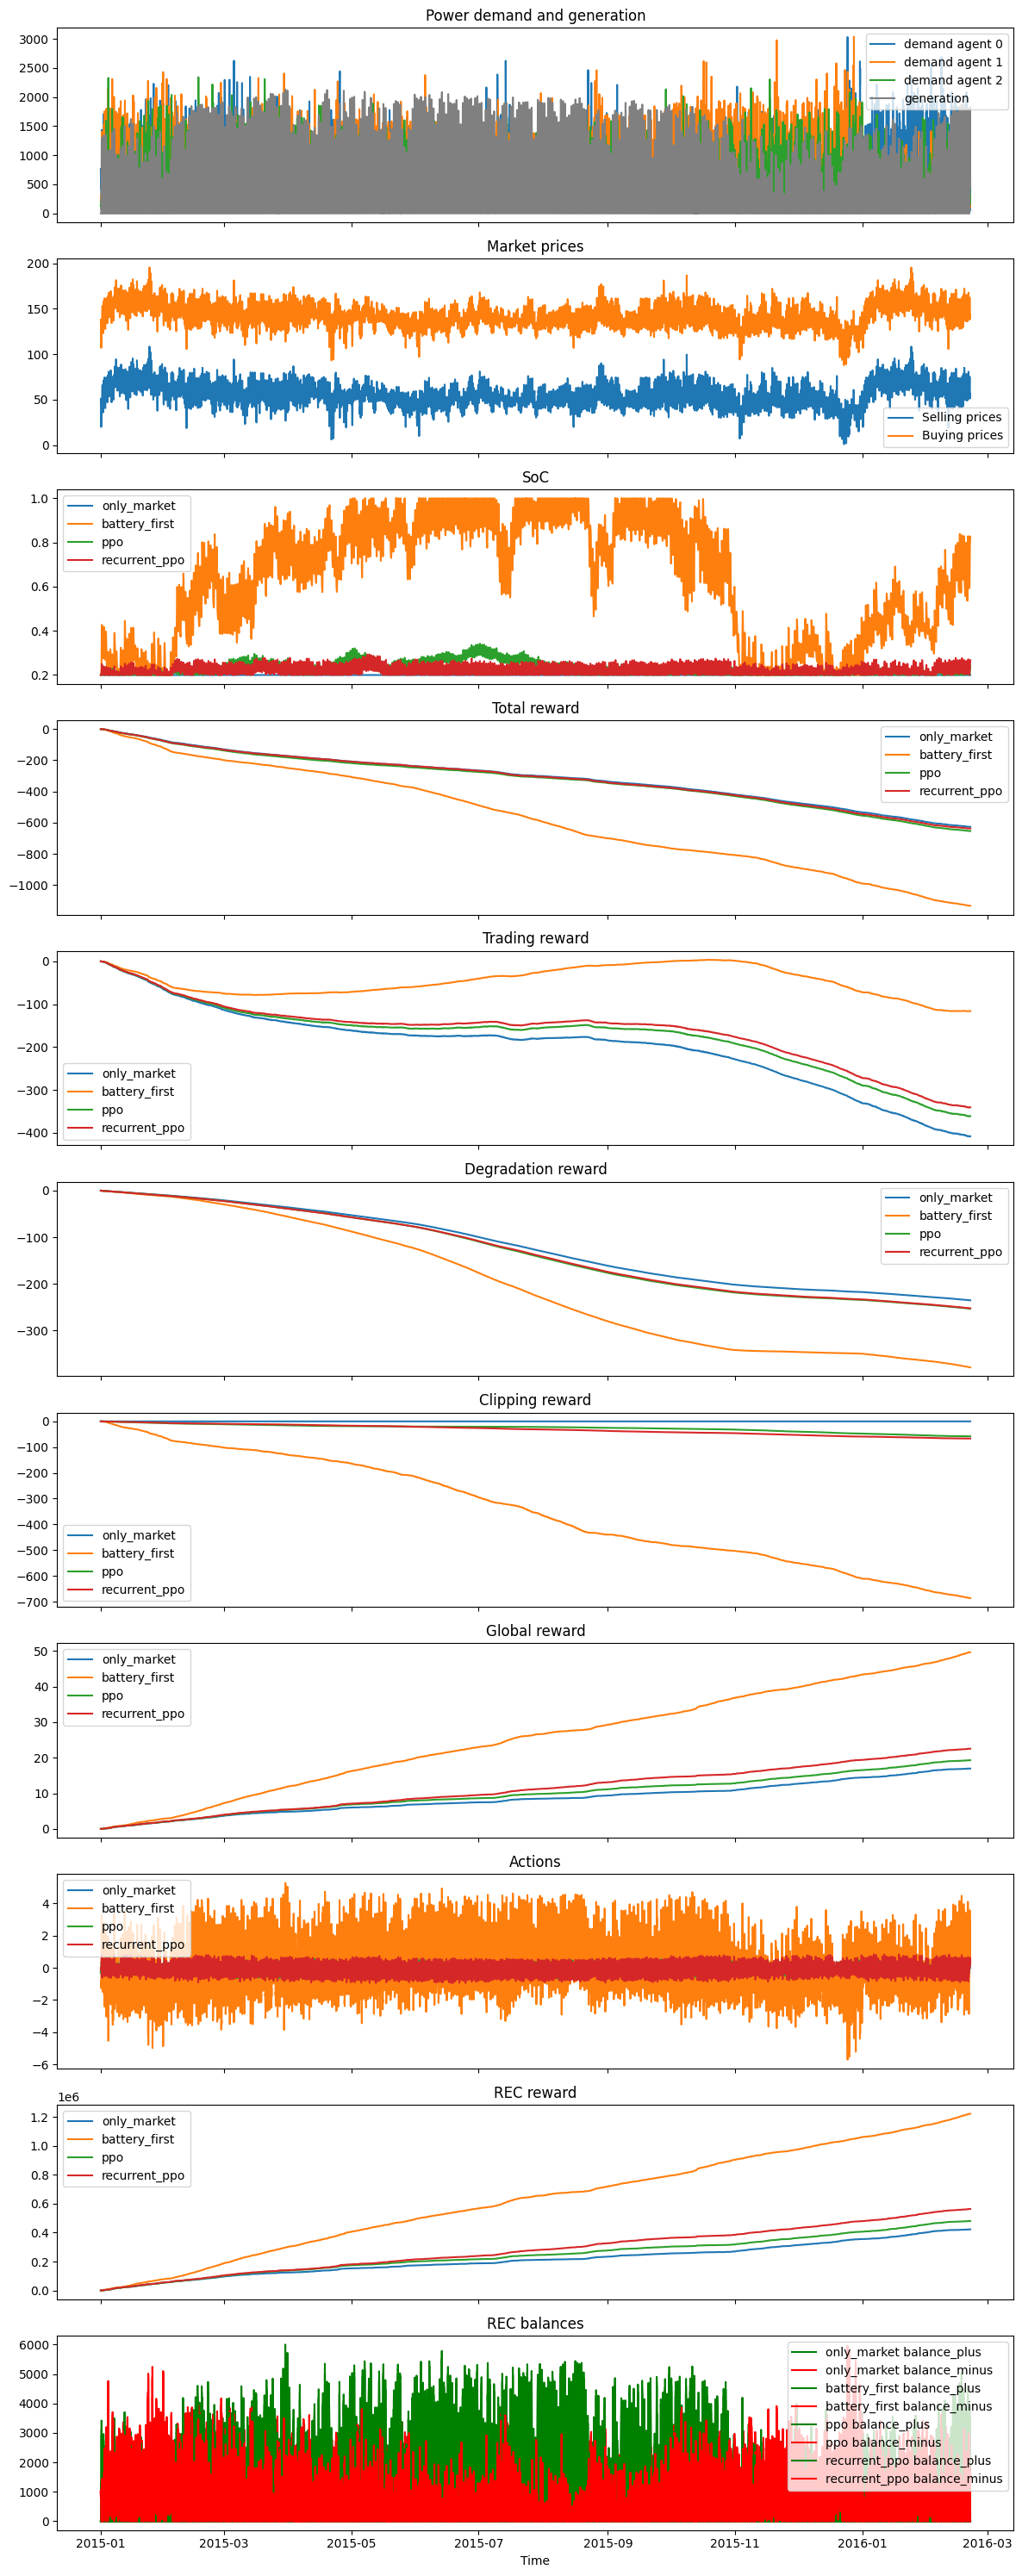

In [42]:
time_limit = 10000

algs_to_plot = ['only_market', 'battery_first', 'ppo', 'recurrent_ppo']
# algs_to_plot = ['ppo']      # ['only_market', 'ppo', 'recurrent_ppo']
full_algs = [] #['ppo']      #['only_market', 'ppo', 'recurrent_ppo']

log_slice = jax.tree.map(lambda x: x[:time_limit], logs)
plot_data_matplotlib(log_slice['ppo']['demands'], log_slice['ppo']['generations'], log_slice['ppo']['sell_prices'], log_slice['ppo']['buy_prices'], log_slice, algs_to_plot, full_algs, env.env_step, reward_type='weig_reward')

In [43]:
# plot_ext_data_and_reward_plotly(logs['ppo']['demand'], logs['ppo']['generation'], logs['ppo']['sell_price'], logs['ppo']['buy_price'], logs, algs_to_plot, env.params.env_step)

In [44]:
# plot_details_reward_plotly(logs, algs_to_plot, env.params.env_step)

In [45]:
summary = {}

for alg in algs:
    summary[alg] = {'mean_soc': np.mean(logs[alg]['soc']),
                    'r_tot': np.sum(logs[alg]['r_tot']),
                    # 'norm_reward': {'r_trad': np.sum(logs[alg]['norm_reward']['r_trad']),
                    #                 # 'r_op': np.sum(logs[alg]['norm_reward']['r_op']),
                    #                 'r_deg': np.sum(logs[alg]['norm_reward']['r_deg']),
                    #                 'r_clipping': np.sum(logs[alg]['norm_reward']['r_clipping'])},
                    'weig_reward': {'r_trad': np.sum(logs[alg]['weig_reward']['r_trad']),
                                    # 'r_op': np.sum(logs[alg]['weig_reward']['r_op']),
                                    'r_deg': np.sum(logs[alg]['weig_reward']['r_deg']),
                                    'r_clipping': np.sum(logs[alg]['weig_reward']['r_clipping'])},
                    'pure_reward': {'r_trad': np.sum(logs[alg]['pure_reward']['r_trad']),
                                    # 'r_op': np.sum(logs[alg]['pure_reward']['r_op']),
                                    'r_deg': np.sum(logs[alg]['pure_reward']['r_deg']),
                                    'r_clipping': np.sum(logs[alg]['pure_reward']['r_clipping'])},
                    'mean_action': np.mean(logs[alg]['actions']),
                    'max_action': np.max(logs[alg]['actions']),
                    'min_action': np.min(logs[alg]['actions']),
                    'variance_action': np.var(logs[alg]['actions']),
                    'final_soh': logs[alg]['soh'][-1],}

flatten_summary = {}

for alg in algs:
    flatten_summary[alg] = {}
    for key in summary[alg].keys():
        if isinstance(summary[alg][key], dict):
            flatten_summary[alg].update([(key+'.'+subkey, summary[alg][key][subkey]) for subkey in summary[alg][key].keys()])
        else:
            flatten_summary[alg][key] = summary[alg][key]


KeyError: 'actions'

In [31]:
df = pd.DataFrame.from_dict(flatten_summary, orient='index')
pd.set_option('display.max_columns', None)
df

mean_soc          r_tot  weig_reward.r_trad  weig_reward.r_deg  \
random         0.598552 -501489.218750      -102757.203125      -50527.925781   
only_market    0.200000  -12039.757812        -5948.747070       -6091.011230   
battery_first  0.761144  -32342.226562        -1731.479614      -10344.604492   
ppo            0.217549  -12644.393555        -4515.269531       -6484.864258   
recurrent_ppo  0.220387  -11387.691406        -3963.334229       -6548.811523   

               weig_reward.r_clipping  pure_reward.r_trad  pure_reward.r_deg  \
random                 -348204.093750       -51281.417969      -50527.925781   
only_market                  0.000000        -3229.083740       -6091.011230   
battery_first           -20266.142578        -1142.564697      -10344.604492   
ppo                      -1644.259888        -2528.104248       -6484.864258   
recurrent_ppo             -875.544312        -2251.621582       -6548.811523   

               pure_reward.r_clipping  mean_action  max_action  min_action  \
random                   -904401472.0    -0.050749   47.999886  -47.999977   
only_market                       0.0     0.000000    0.000000    0.000000   
battery_first             -52719604.0     0.291413    5.812455   -9.776364   
ppo                        -4263321.5    -0.050175    0.456598   -0.795225   
recurrent_ppo              -2302751.5    -0.027100    1.007216   -1.188642   

               variance_action  final_soh  
random              767.323303   0.845574  
only_market           0.000000   0.970995  
battery_first         3.654005   0.952736  
ppo                   0.079188   0.969126  
recurrent_ppo         0.176985   0.968848

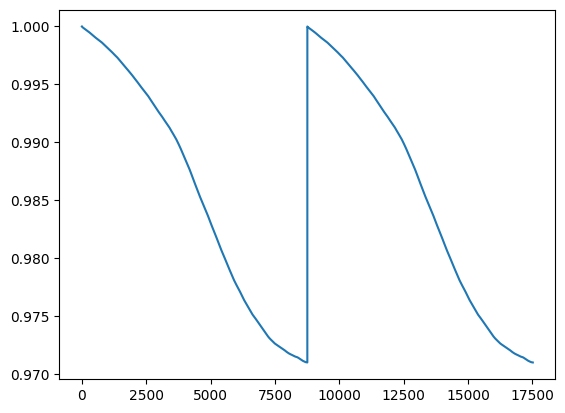

In [32]:
plt.plot(logs['only_market']['soh'][:int(len(logs['ppo']['soh'])/14)])